### EDA for musdb dataset used for model decomposition training

In [1]:
from IPython.display import Audio, display
import stempeg
from tqdm.notebook import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from scipy import signal
import librosa
import pywt
import scipy
from typing import List

train_path = "../data/01_raw/train"


In [2]:
signals, rates = [], []

In [4]:
for track in tqdm(os.listdir(train_path)[:6]):
    if not track.endswith(".mp4"):
        continue
    S, rate = stempeg.read_stems(os.path.join(train_path, track))
    signals.append(S)
    rates.append(rate)


  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
S = signals[1]
rate = rates[1]
print(S.shape)
print("Mixture")
display(Audio(S[0,:111646, :].T, rate=rate))

(5, 7299072, 2)
Mixture


In [5]:
print("Drums")
display(Audio(S[1,:111646, :].T, rate=rate))

Drums


In [6]:
print("Bass")
display(Audio(S[2,:111646, :].T, rate=rate))

Bass


In [7]:
print("Other")
display(Audio(S[3, :111646, :].T, rate=rate))

Other


In [8]:
print("Vocals")
display(Audio(S[4, :111646, :].T, rate=rate))

Vocals


/home/agorski/.cache/pypoetry/virtualenvs/pipelines-FR1Vnxxs-py3.10/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/agorski/.cache/pypoetry/virtualenvs/pipelines-FR1Vnxxs-py3.10/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


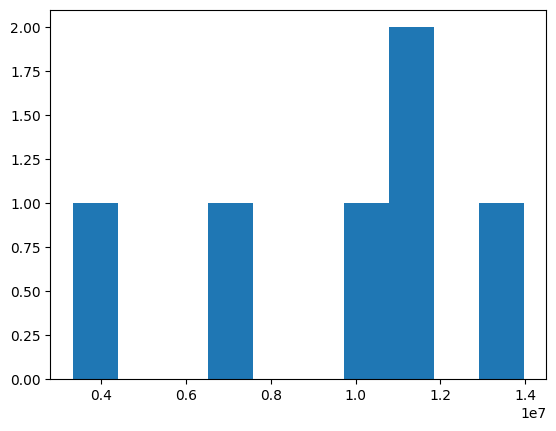

In [9]:
plt.hist(list(map(lambda x: x.shape[1], signals)))
plt.show()

In [10]:
example_signal, example_rate = signals[5], rates[5]

In [11]:
mixture = example_signal[0]
drums = example_signal[1]
bass = example_signal[2]
other = example_signal[3]
vocals = example_signal[4]
time = np.arange(mixture.shape[0])

In [12]:
print(mixture.shape)

(13972480, 2)


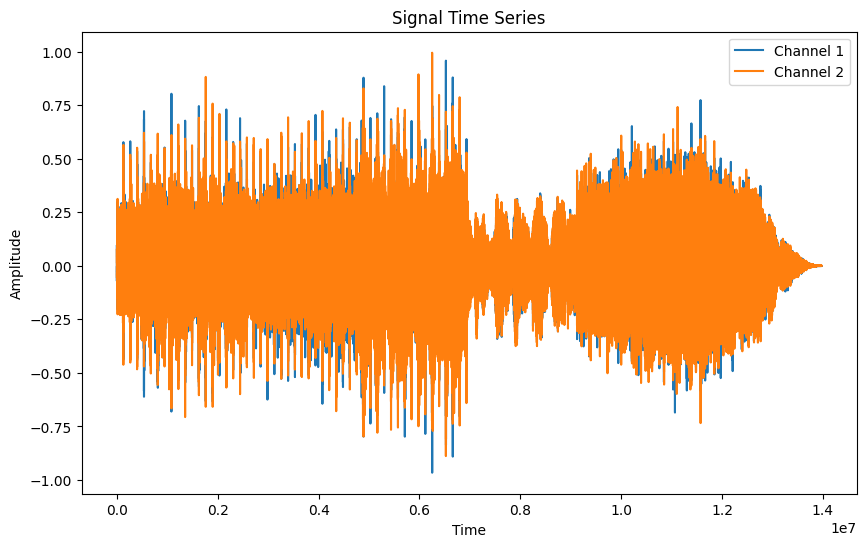

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(time, mixture[:, 0], label='Channel 1')
plt.plot(time, mixture[:, 1], label='Channel 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal Time Series')
plt.legend()

plt.show()

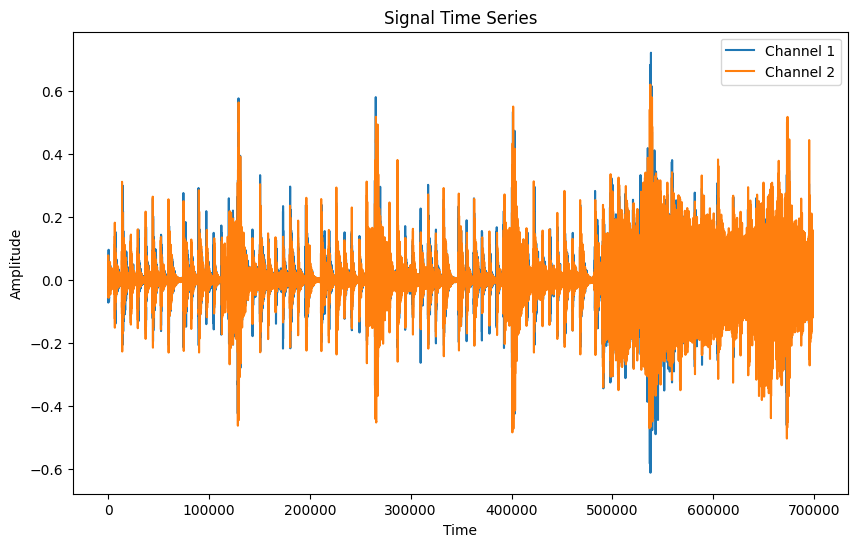

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(time[:len(mixture)//20], mixture[:len(mixture)//20, 0], label='Channel 1')
plt.plot(time[:len(mixture)//20], mixture[:len(mixture)//20, 1], label='Channel 2')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal Time Series')
plt.legend()

plt.show()

In [15]:
print(example_signal[:, :, 1].flatten()[:10])

[0.01676763 0.02176076 0.02061772 0.02338479 0.0237743  0.02326265
 0.02435926 0.02415329 0.02327816 0.02151847]


In [16]:
print(mixture.shape)

(13972480, 2)


#### Time domain

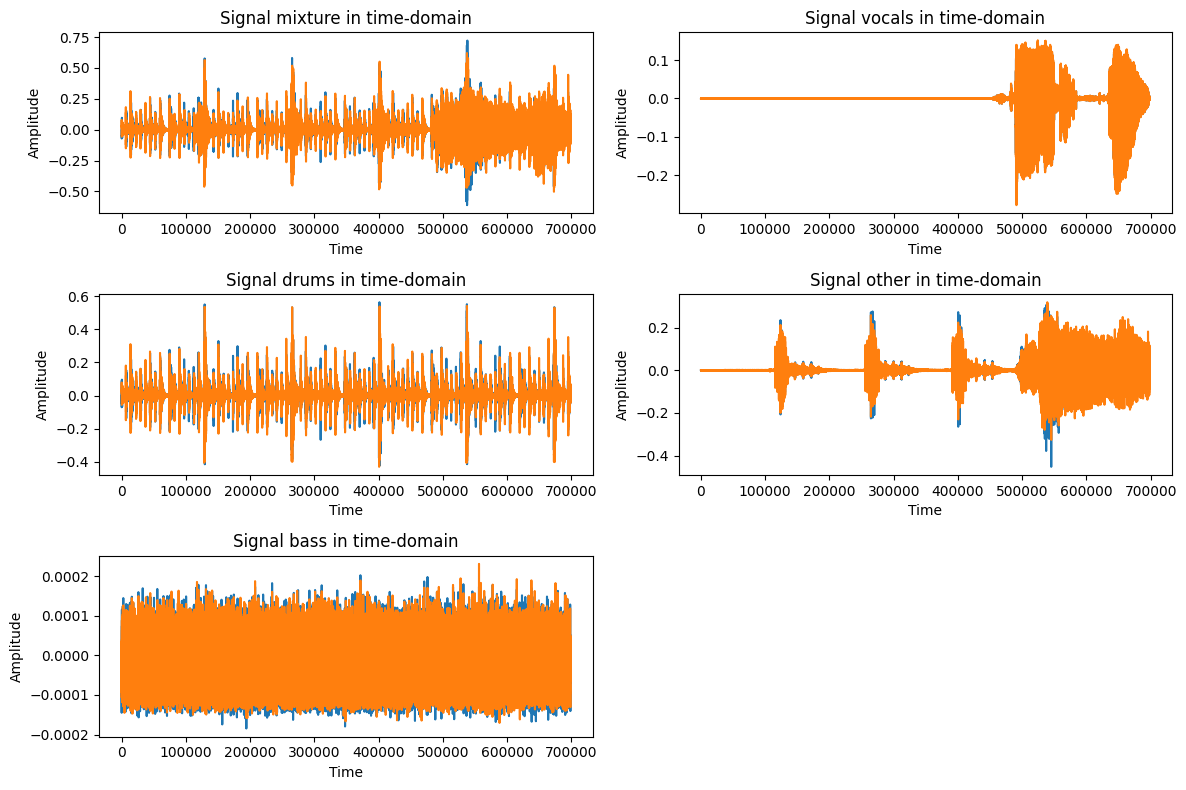

In [17]:
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes[-1, -1].remove()

signal_names = ["mixture", "vocals", "drums", "other", "bass"]
for i, (signal, singal_name) in enumerate(zip([mixture, vocals, drums, other, bass], signal_names)):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.plot(time[:len(signal)//20], signal[:len(signal)//20, 0], label='Channel 1')
    ax.plot(time[:len(signal)//20], signal[:len(signal)//20, 1], label='Channel 2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Signal {singal_name} in time-domain')

plt.tight_layout()
plt.show()

- In case of mixture, there can be noticed a clear pattern despite the noise.
- Vocals are only noticeable during the parts of the songs - they seem to have similar amplitudes but lack periodicity.
- Drums on the other hand have similar both periodicity and similar amplitudes. Each different amplitude can be attributed to different drum or cymbal.
- Other domain seems to consist of several different components which follow regular but distinctive patterns.
- Bass seems to noisy with a lack of clear amplitudes or periodicity. It does not have any clear valleys or peaks.

#### Frequency domain

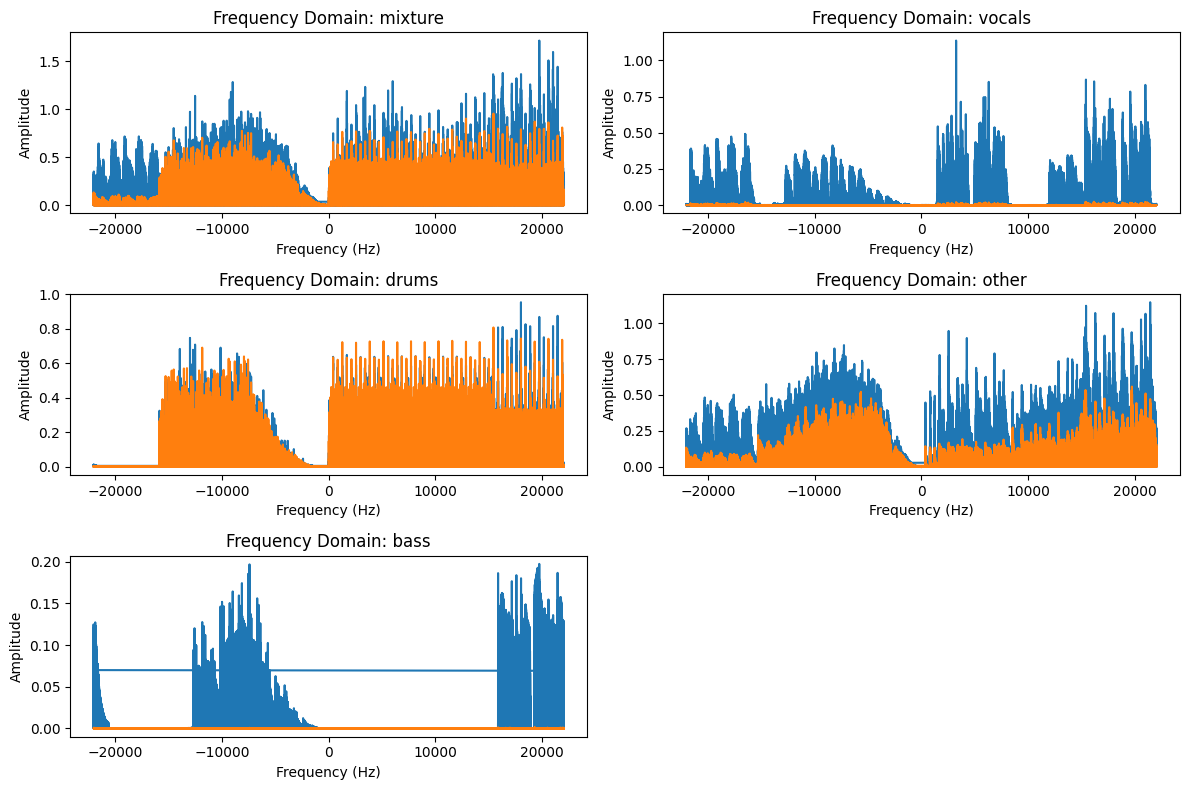

In [18]:
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes[-1, -1].remove()

signal_names = ["mixture", "vocals", "drums", "other", "bass"]
for i, (signal, singal_name) in enumerate(zip([mixture, vocals, drums, other, bass], signal_names)):
    # Perform FFT
    fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)  # Frequency axis
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.plot(frequencies, np.abs(fft))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Frequency Domain: {singal_name}')
    
plt.tight_layout()
plt.show()

- In case of mixture it is hard to find clear dominant frequencies, all of them seem to be harmonically distributed which can be interpreted as a mixture of various sources.
- For vocals, it seems that there are some dominant frequencies with lower one representing male lead vocalist and higher one that can be attributed to a female choir.
- Both drums and cymbals can be easily observed - it is worth noting that they seem to be equally popular. This means that often they are often one after another.
- In other domain there are multiple dominant frequencies suggesting radically different sources
- Bass seems to have 3 different sources, each with similar popularity.

#### Spectogram analysis

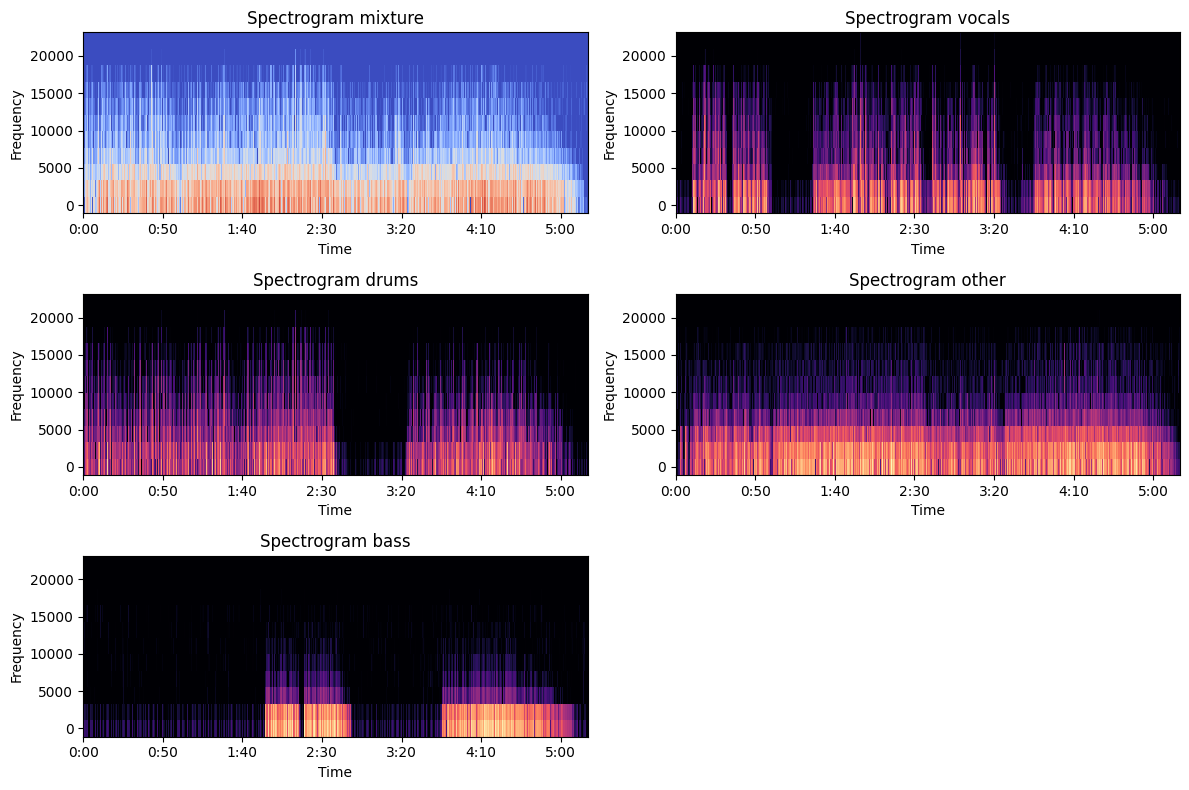

In [19]:
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes[-1, -1].remove()

signal_names = ["mixture", "vocals", "drums", "other", "bass"]
for i, (signal, singal_name) in enumerate(zip([mixture, vocals, drums, other, bass], signal_names)):
    spectrogram = librosa.stft(signal[:, 0], n_fft=20, hop_length=512)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    librosa.display.specshow(spectrogram_db, sr=rate, hop_length=512,
                            x_axis='time', y_axis='linear', ax=ax)
    ax.set_title(f'Spectrogram {singal_name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # plt.colorbar(format='%+2.0f dB', ax=ax)

plt.tight_layout()
plt.show()

- Time analysis of vocals show that there are sharp increases or values close to 0, this means that the vocalist tends to either sing his part or be silent. This can be also interpreted as lack of background speech or limited noise.
- The same can be said about drums - there is a sharp increase suggesting a drummer hitting an instrument.
- For bass and the other values seem to be having less sharp increases suggesting more even distribution, for example the bass is playing for much longer but with more varied power.

#### Wavelet analysis

/home/agorski/.cache/pypoetry/virtualenvs/pipelines-FR1Vnxxs-py3.10/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


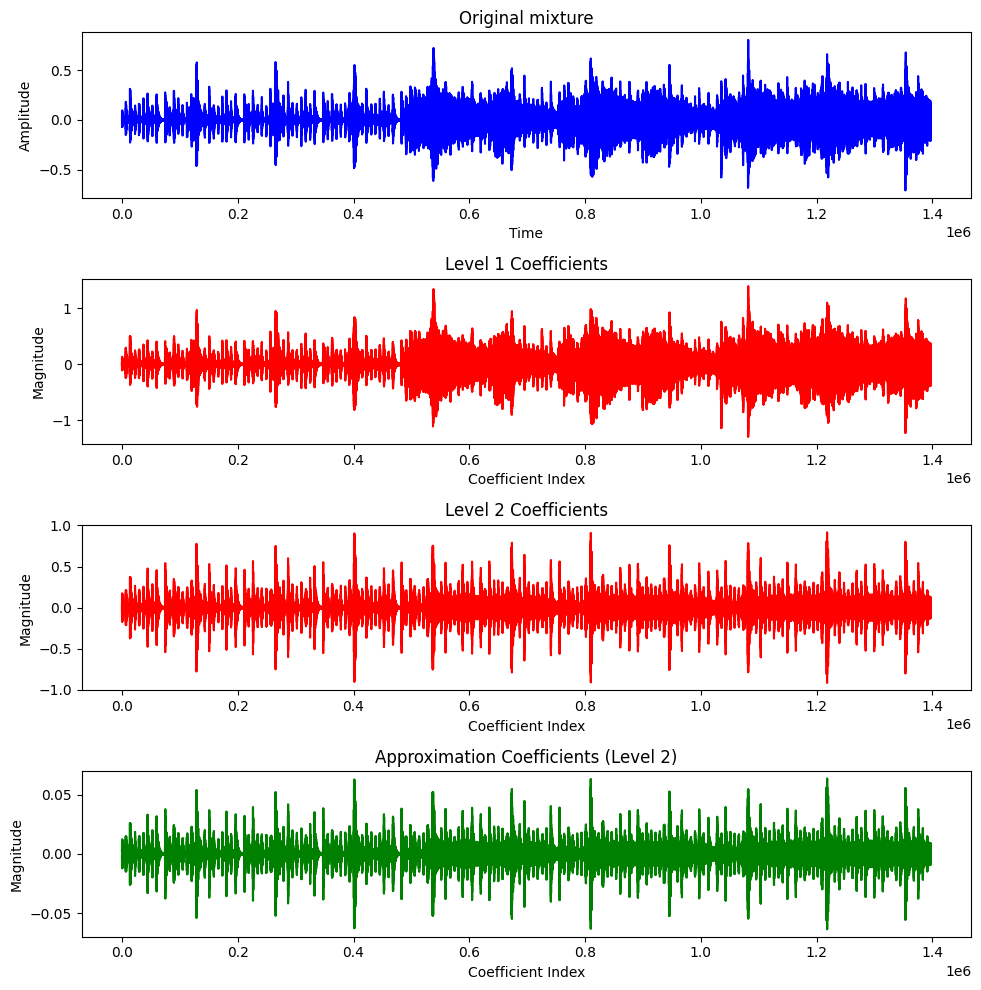

In [21]:
wavelet = 'db4'
level = 2
coeffs = pywt.wavedec(mixture[:1397248, :], wavelet, level=level)

plt.figure(figsize=(10, 10))
plt.subplot(level+2, 1, 1)
plt.plot(np.arange(len(mixture[:1397248, :])), mixture[:1397248, :], 'b')
plt.title('Original mixture')
plt.xlabel('Time')
plt.ylabel('Amplitude')

for i in range(level):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i], 'r')
    plt.title(f'Level {i+1} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')

plt.subplot(level+2, 1, level+2)
plt.plot(coeffs[level], 'g')
plt.title(f'Approximation Coefficients (Level {level})')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

- Differences between level 2 coefficients and original signal indicate certain issues with compression, signal might be noisy.
- There are some frequencies among level 2 coefficients that are much more prevalent than in original signal. This might indicate some important features.
- Decomposition also struggles with some localized events suggesting radical changes in the signal - maybe a sudden sound.

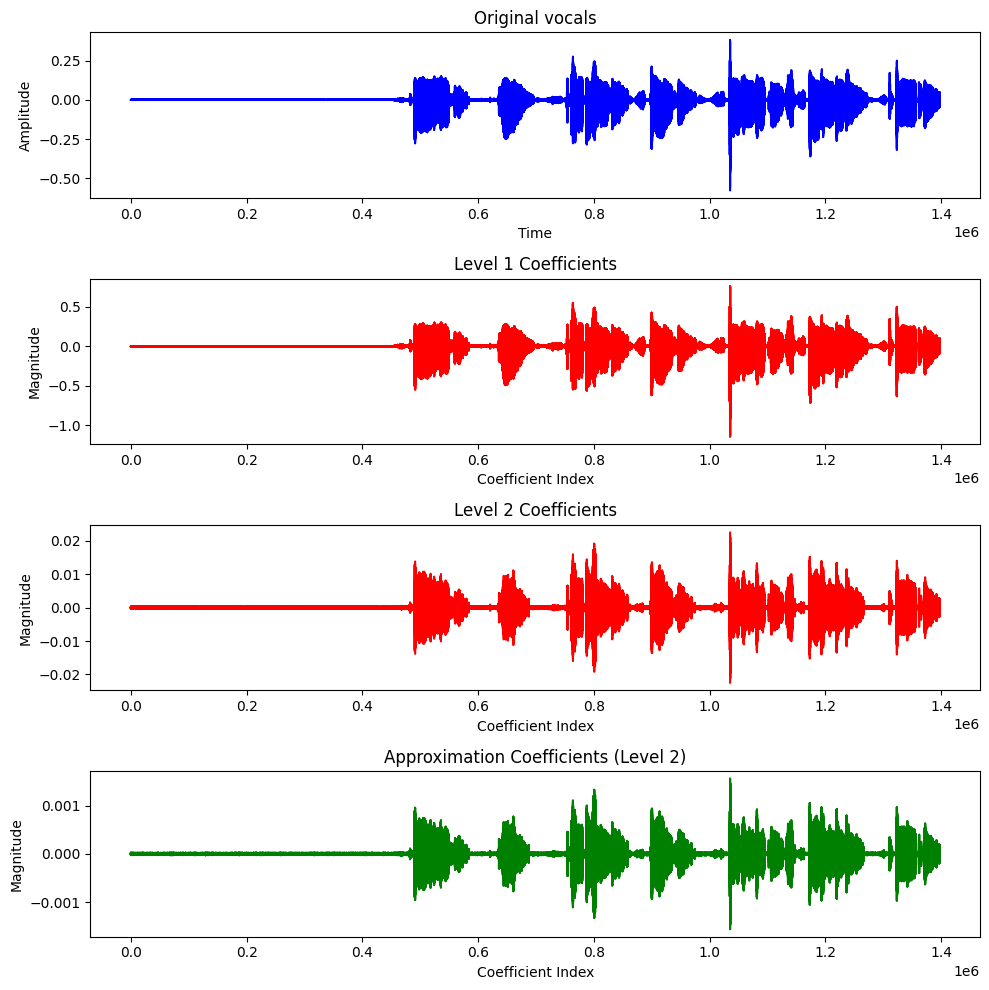

In [22]:
wavelet = 'db4'  # Choose a wavelet function, such as Daubechies 4
level = 2# Number of decomposition levels
coeffs = pywt.wavedec(vocals[:1397248, :], wavelet, level=level)

# Plot the original signal
plt.figure(figsize=(10, 10))
plt.subplot(level+2, 1, 1)
plt.plot(np.arange(len(vocals[:1397248, :])), vocals[:1397248, :], 'b')
plt.title('Original vocals')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the wavelet coefficients
for i in range(level):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i], 'r')
    plt.title(f'Level {i+1} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')

# Plot the approximation coefficients (last level)
plt.subplot(level+2, 1, level+2)
plt.plot(coeffs[level], 'g')
plt.title(f'Approximation Coefficients (Level {level})')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

- The situation for vocals is radically different for vocals than for the whole mixture.
- There doesn't seem to be any issues with approximation, dominant frequencies and localized events.

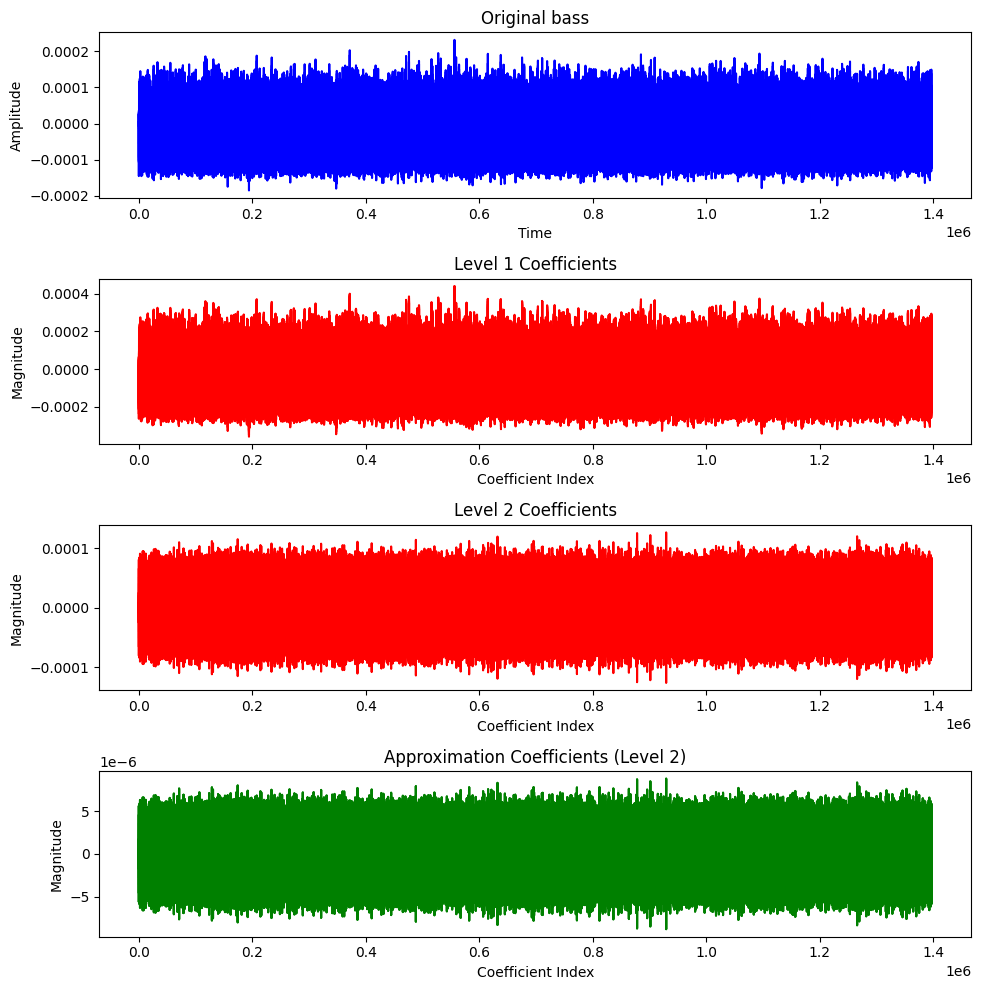

In [23]:
wavelet = 'db4'  # Choose a wavelet function, such as Daubechies 4
level = 2# Number of decomposition levels
coeffs = pywt.wavedec(bass[:1397248, :], wavelet, level=level)

# Plot the original signal
plt.figure(figsize=(10, 10))
plt.subplot(level+2, 1, 1)
plt.plot(np.arange(len(bass[:1397248, :])), bass[:1397248, :], 'b')
plt.title('Original bass')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the wavelet coefficients
for i in range(level):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i], 'r')
    plt.title(f'Level {i+1} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')

# Plot the approximation coefficients (last level)
plt.subplot(level+2, 1, level+2)
plt.plot(coeffs[level], 'g')
plt.title(f'Approximation Coefficients (Level {level})')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

- Wavelets analysis for bass suggests no localized events so it is impossible to make any observations based on it.

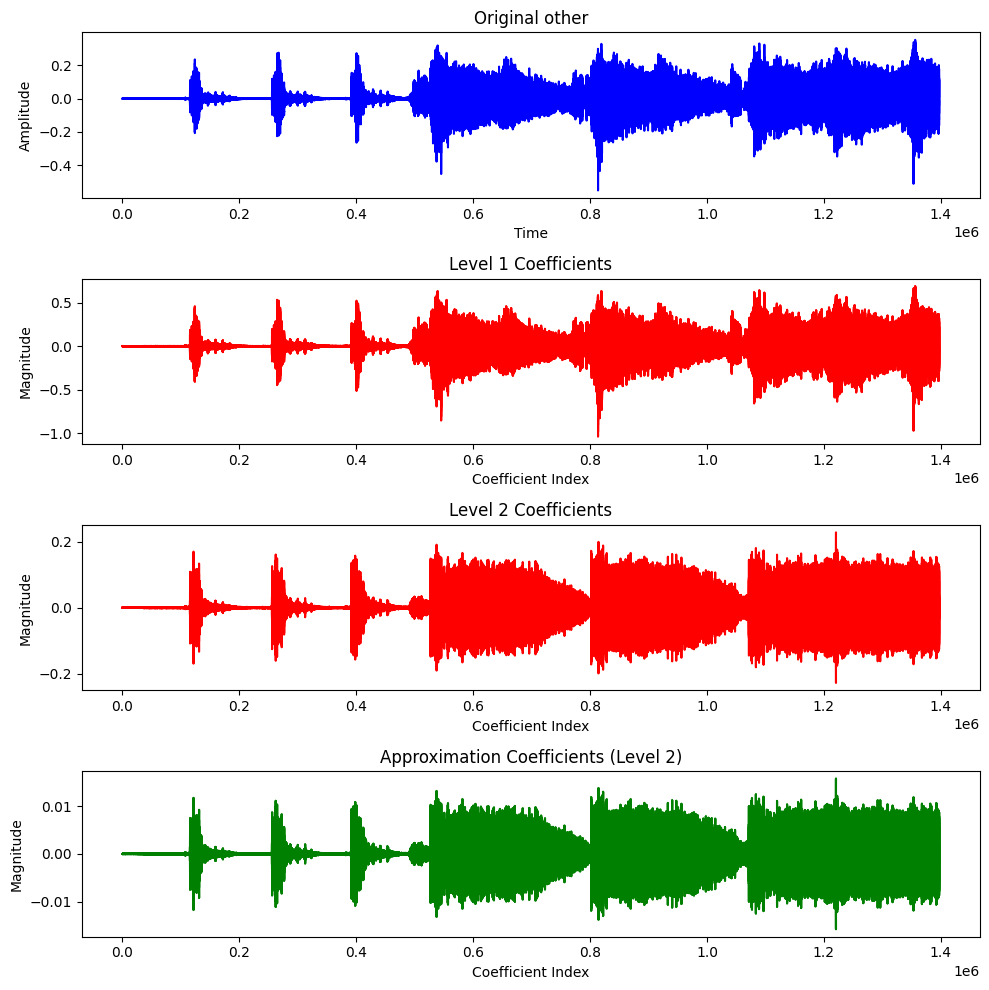

In [24]:
wavelet = 'db4'  # Choose a wavelet function, such as Daubechies 4
level = 2# Number of decomposition levels
coeffs = pywt.wavedec(other[:1397248, :], wavelet, level=level)

# Plot the original signal
plt.figure(figsize=(10, 10))
plt.subplot(level+2, 1, 1)
plt.plot(np.arange(len(other[:1397248, :])), other[:1397248, :], 'b')
plt.title('Original other')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the wavelet coefficients
for i in range(level):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i], 'r')
    plt.title(f'Level {i+1} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')

# Plot the approximation coefficients (last level)
plt.subplot(level+2, 1, level+2)
plt.plot(coeffs[level], 'g')
plt.title(f'Approximation Coefficients (Level {level})')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

- Coefficients are close to original signal and very well approximate localized events.

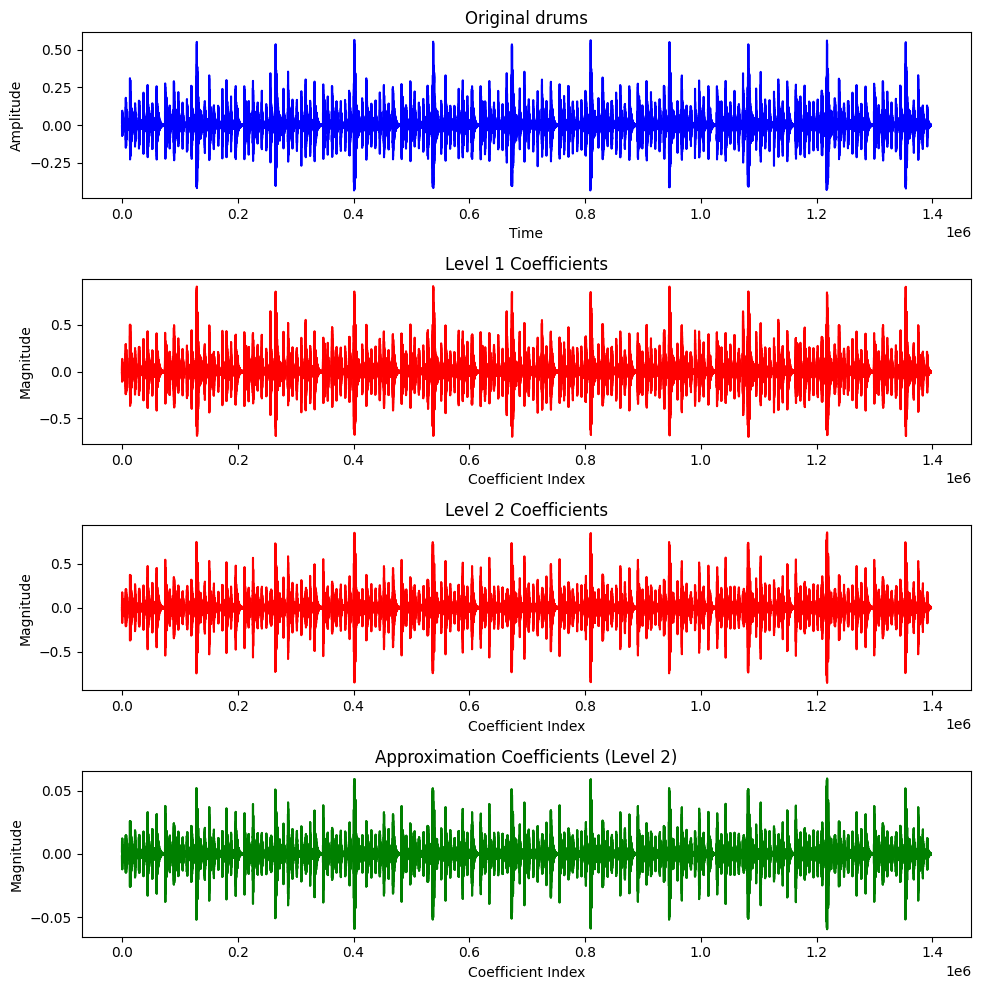

In [25]:
wavelet = 'db4'  # Choose a wavelet function, such as Daubechies 4
level = 2# Number of decomposition levels
coeffs = pywt.wavedec(drums[:1397248, :], wavelet, level=level)

# Plot the original signal
plt.figure(figsize=(10, 10))
plt.subplot(level+2, 1, 1)
plt.plot(np.arange(len(drums[:1397248, :])), drums[:1397248, :], 'b')
plt.title('Original drums')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot the wavelet coefficients
for i in range(level):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i], 'r')
    plt.title(f'Level {i+1} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Magnitude')

# Plot the approximation coefficients (last level)
plt.subplot(level+2, 1, level+2)
plt.plot(coeffs[level], 'g')
plt.title(f'Approximation Coefficients (Level {level})')
plt.xlabel('Coefficient Index')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

- The same can be said about drums.

# Autocorrelation

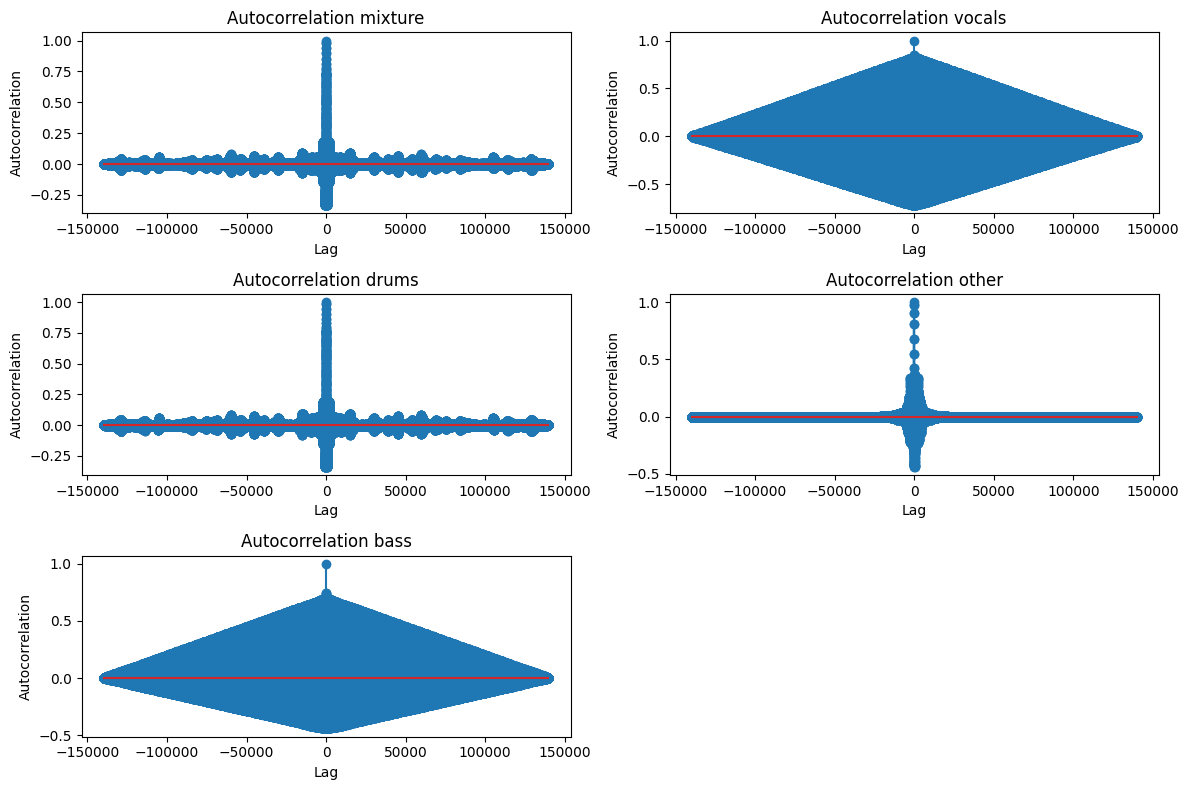

In [27]:
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes[-1, -1].remove()

signal_names = ["mixture", "vocals", "drums", "other", "bass"]
for i, (signal, signal_name) in enumerate(zip([mixture, vocals, drums, other, bass], signal_names)):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    autocorr = np.correlate(signal[:139724,0], signal[:139724,0], mode='full')
    autocorr /= np.max(autocorr)
    lags = np.arange(-len(signal[:139724,0]) + 1, len(signal[:139724,0]))
    ax.stem(lags, autocorr)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation {signal_name}')


plt.tight_layout()
plt.show()

- There seem to be some limited autocorrelation at lags different to zero for both mixture and drums.
- All of the other signals dotn seem to be autocorrelated at all.
- There is a very strong autocorrelation for bass and vocals suggesting clear periodicity and repetitive patterns.

#### Statistical measures

In [41]:
def calculate_metrics(signals: List[np.typing.NDArray], signal_names: List[str]) -> pd.DataFrame:

    stats = {
        "Name": [],
        "Mean": [],
        "Median": [],
        "Mode": [],
        "Std_dev": [],
        "Variance": [],
        "Skewness": [],
        "Kurtosis": [],
        "Signal_range": [],
        "Percentile_25": [],
        "Percentile_75": [],
        "Iqr": [],
    }
    for signal_param, signal_name in zip(signals, signal_names):
        stats["Name"].append(signal_name)

        stats["Mean"].append(np.mean(signal_param))
        stats["Median"].append(np.median(signal_param))
        stats["Mode"].append(scipy.stats.mode(signal_param).mode[0])
        stats["Std_dev"].append(np.std(signal_param))
        stats["Variance"].append(np.var(signal_param))
        stats["Skewness"].append(scipy.stats.skew(signal_param))
        stats["Kurtosis"].append(scipy.stats.kurtosis(signal_param))
        stats["Signal_range"].append(np.ptp(signal_param))
        stats["Percentile_25"].append(np.percentile(signal_param, 25))
        stats["Percentile_75"].append(np.percentile(signal_param, 75))
        stats["Iqr"].append(np.subtract(*np.percentile(signal_param, [75, 25])))

    df = pd.DataFrame(stats)
    return df

stats_df = calculate_metrics([mixture[:, 0], vocals[:, 0], drums[:, 0], other[:, 0], bass[:, 0]], ["mixture", "vocals", "drums", "other", "bass"])
stats_df

/tmp/ipykernel_5000/2994468204.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats["Mode"].append(scipy.stats.mode(signal_param).mode[0])


Name      Mean    Median      Mode   Std_dev  Variance  Skewness  \
0  mixture -0.000015  0.000018 -0.095214  0.088990  0.007919 -0.008594   
1   vocals -0.000015  0.000006 -0.077934  0.041541  0.001726 -0.642568   
2    drums -0.000017 -0.000045 -0.018114  0.037280  0.001390  0.671502   
3    other -0.000016 -0.000056  0.031968  0.067680  0.004581  0.015085   
4     bass -0.000014 -0.000011 -0.027867  0.016267  0.000265  0.122664   

    Kurtosis  Signal_range  Percentile_25  Percentile_75       Iqr  
0   2.516006      1.923868      -0.044932       0.045516  0.090448  
1   4.636887      0.965525      -0.005442       0.007985  0.013427  
2  25.928745      1.230976      -0.006339       0.005458  0.011797  
3   2.036604      1.224304      -0.034107       0.033719  0.067826  
4   4.770967      0.191808      -0.000077       0.000045  0.000122

- Means for all the signals seem to be similar suggesting they have similar volume,
- The other signal seems to be the most varied, even more than mixture,
- Bass seems to have much more extreme distribution shape than other based on its kurtosis score
- Also based on Iqr, mixture has much more varied values with bass' values being the most similar ones

#### Features extraction

In [88]:
def calculate_spectral_metrics(signals: List[np.typing.NDArray], signal_names: List[str]) -> pd.DataFrame:

    stats = {
        "Name": [],
        "Tempo": [],
        "Poly_features": [],
        "Spectral_centroid": [],
        "Spectral_bandwidth": [],
        "Spectral_contrast": [],
        "Spectral_flatness": [],
        "Spectral_rolloff": [],
        "Zero_crossing_rate": [],
        "Tonnetz": [],
    }

    for signal, signal_name in tqdm(zip(signals, signal_names), total=len(signals)):
        stats["Name"].append(str(signal_name))
        stats["Tempo"].append(str(librosa.feature.tempo(y=signal[:10000000], sr=rate)[0]))
        stats["Poly_features"].append(str(librosa.feature.poly_features(y=signal[:10000000], sr=rate)[0, 0]))
        stats["Spectral_centroid"].append(str(librosa.feature.spectral_centroid(y=signal[:10000000], sr=rate)[0, 0]))
        stats["Spectral_bandwidth"].append(str(librosa.feature.spectral_bandwidth(y=signal[:10000000], sr=rate)[0, 0]))
        stats["Spectral_contrast"].append(str(librosa.feature.spectral_contrast(y=signal[:10000000], sr=rate)[0, 0]))
        stats["Spectral_flatness"].append(str(librosa.feature.spectral_flatness(y=signal[:10000000])[0, 0]))
        stats["Spectral_rolloff"].append(str(librosa.feature.spectral_rolloff(y=signal[:10000000], sr=rate)[0, 0]))
        stats["Zero_crossing_rate"].append(str(librosa.feature.zero_crossing_rate(y=signal[:10000000])[0, 0]))
        stats["Tonnetz"].append(str(librosa.feature.tonnetz(y=signal[:10000000])[0, 0]))

    df = pd.DataFrame(stats)
    return df

spectral_df = calculate_spectral_metrics([mixture[:, 0], vocals[:, 0], drums[:, 0], other[:, 0], bass[:, 0]], ["mixture", "vocals", "drums", "other", "bass"])
spectral_df

  0%|          | 0/5 [00:00<?, ?it/s]

Name               Tempo            Poly_features   Spectral_centroid  \
0  mixture  117.45383522727273   -2.911294695397129e-05   1245.331440639478   
1   vocals  120.18531976744185   -1.971253499903025e-07   6842.835902099341   
2    drums  117.45383522727273  -2.8930232168221533e-05  1234.8906908092888   
3    other  117.45383522727273  -2.9673925640396425e-07   6971.285139837753   
4     bass  120.18531976744185   -3.603015777934107e-08   7663.372174496187   

   Spectral_bandwidth   Spectral_contrast       Spectral_flatness  \
0   2657.152078902056    8.59743471710976   0.0002071376010032622   
1   5670.754692396739  10.458438718825256    0.024718641350221036   
2  2633.7197780851084   8.664589056033817  0.00020025877705459502   
3   5827.471241298197  10.865031313999724    0.035549529330181656   
4    5699.68393664806  10.270918219365281     0.03206759491267487   

  Spectral_rolloff Zero_crossing_rate                Tonnetz  
0   2605.517578125         0.00390625    0.02004817511213819  
1     13953.515625      0.10205078125   -0.08722576430860134  
2   2605.517578125         0.00390625    0.02544961699481516  
3    14211.9140625       0.0791015625   -0.06971654157432228  
4  14621.044921875      0.11669921875  -0.026530282511693218

- The pace of all the signals seems to be similar
- Drums seem to have the closes poly features to the mixture indicating spectral similarity between them and noise or different artifacts between mixture and the others
- Both vocals and the other as well as mixture and drums seem to have similar tone balance based on theirs spectral centroids.
- Based on spectral bandwidth mixture and vocals seem to be similar less diverse music sources, while vocals, other and drums are very diverse.
- All the signals seem to be highly inharmonic and spread around various frequencies with other and bass having seemingly slightly more harmony.